<a href="https://colab.research.google.com/github/Kodhandarama/Audio_Analysis/blob/master/tonic%2Bpitch_histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#connects colab to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
print("hello")

hello


In [0]:
#importing nessecary libraries
import librosa
import librosa.display
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import *
from scipy.signal import kaiserord, lfilter, firwin, freqz, spectrogram
plt.rcParams['figure.figsize'] = [10, 5]
freq_cqt = librosa.cqt_frequencies(90, fmin=32)
                                   

In [0]:
#defining the class 
#each object of this class is an audio clip that is to be analysed
class Audio:
  def __init__(self, path, sr=None, duration = None):
    
    self.x, self.sr1 = librosa.load(path= path, sr=sr,duration=duration)
    
    nyq_rate = self.sr1 / 2.0
    width = 5.0/nyq_rate
    N, beta = kaiserord(60.0, width)
    taps = firwin(N, [i/nyq_rate for i in [110.0, 500.0]], window=('kaiser', beta),pass_zero=False)
    
    self.x = lfilter(taps, 1.0, self.x)
    self.time = librosa.samples_to_time(np.arange(0,len(librosa.frames_to_time(self.x,sr=self.sr1)),512))/2
    
    self.spectrogram()
    self.pitch_contour()

  def spectrogram(self,plot = False):
    cqt = librosa.cqt(self.x,sr=self.sr1)
    self.logC = librosa.amplitude_to_db(np.abs(cqt),ref = np.max)
    if plot:
      librosa.display.specshow(self.logC, sr=self.sr1, x_axis='time',y_axis = 'cqt_hz')
  """
  def spectrogram(self,plot = False):
    stft = librosa.stft(self.x)
    S, phase = librosa.magphase(stft)
    self.logC = librosa.amplitude_to_db(S,ref = np.max)
    if plot:
      librosa.display.specshow(self.logC, sr=self.sr1, x_axis='time',y_axis = 'log')
  """
  def low_pass_digital(self,S, dt = 70, ts = 50): #parameters have to be verified
    low = []
    alpha = dt/(int(dt)+ts)
    low.append((1-alpha)*S[0])
    for i in range(1,len(S)):
      g = (1-alpha)*S[i] + alpha*low[i-1]
      low.append(g)
    return low
  def pitch_contour(self):
    pitch = []
    i,j = self.logC.shape
    step = np.ones(j)
    for k in range(0,j):
      temp = np.where(self.logC[:,k]==np.amax(self.logC[:,k]))
      pitch.append(temp[0][0])
      if np.amax(self.logC[:,k]) < -15:  
        step[k] = np.nan
    pitch = [ freq_cqt[i] for i in pitch]
    pitch = self.low_pass_digital(pitch)
    self.pitch = [a*b for a,b in zip(pitch,step)]

    def constant_pitch(self):
    # normalised pitch by 12*log(to the base 2) (f[i]/f0)
    # where f0 is the tonic 
    self.normalised_pitch=[]
    for i in self.pitch:
      self.normalised_pitch.append((12*np.log2(i/191.782)))
    
    # calculating the 1st order difference
    self.diff_n = np.diff(self.normalised_pitch)
    
    k=[]
    for i in range(len(self.diff_n)):
      # constant note when the slope(of the pitch contour) is within the thershold i.e, delta =  
      if(self.diff_n[i]<0.01 and self.diff_n[i]>-0.01):
        k.append((self.normalised_pitch[i],self.time[i]))
    k = np.array(k)
    self.constant_pitch_notes,self.constant_pitch_time = k.T

In [0]:
test = Audio('/content/drive/My Drive/AA/Music dataset/Audio/223580__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-abhogi-raaga.mp3')

In [0]:
test_surabhi = Audio('/content/drive/My Drive/AA/Music dataset/Raga_Surabhi_3.wav')

In [0]:
plt.plot(test.pitch)

In [0]:
test.pitch

In [0]:
#checking the ratio of panchama to shadja

def most_frequent(List): 
    counter = 0
    num = List[0] 
      
    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num  

def tonic(testo):
  store_tonic=list()
  floored=[]
  
  uniquepitch=set(testo.pitch)
  uniquepitchfloor=[]
  for i in uniquepitch:
    if(not((math.isnan(i)))):
      i=math.floor(i)
    uniquepitchfloor.append(i)
  for i in uniquepitchfloor:
    for j in uniquepitchfloor:
        if(not((math.isnan(i)))and (not((math.isnan(j))))):
          if(((i/j)>1.49) and ((i/j) <1.51)):
            # print(j)
            store_tonic.append(j)
  
  print(most_frequent(store_tonic))
  

#tonic(test)


The result seems to be consistent with 242 hz as the tonic

In [0]:
# Now, to test another audio clip
test3=Audio('/content/drive/My Drive/AA/Music dataset/Audio/223586__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-kalyani-raaga.mp3',duration = 40)



In [0]:
plt.plot(test3.pitch)

In [0]:
rkm1=Audio('/content/drive/My Drive/AA/Music dataset/Audio/223580__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-abhogi-raaga.mp3',duration=100)
rkm2=Audio('/content/drive/My Drive/AA/Music dataset/Audio/223588__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-kalyani-raaga.mp3',duration=100)

In [0]:
tonic(rkm1)



In [0]:
tonic(rkm2)

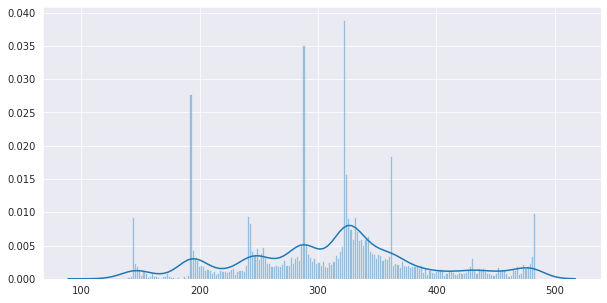

In [0]:
#checking out smooth histograms
import seaborn as sns

test2=Audio('/content/drive/My Drive/AA/Music dataset/Raga_Surabhi_3.wav')
free= test.pitch
plt.rcParams['figure.figsize'] = [10, 5]
# sns.set_style('darkgrid')
sns.distplot(free,bins=200)

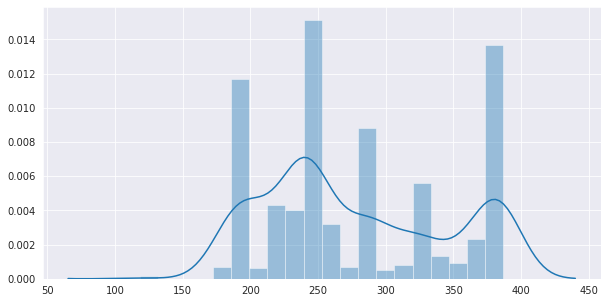

In [0]:
free2= test2.pitch
plt.rcParams['figure.figsize'] = [10, 5]
# sns.set_style('darkgrid')
sns.distplot(free2,bins=20)

https://pages.mtu.edu/~suits/notefreqs.html

In [0]:
most_frequent([i for i in rkm2.pitch if i>320 and i<325])

321.1790100012322